<a href="https://colab.research.google.com/github/FilippoAiraldi/RL-demos/blob/main/lnmb_mab_ex7_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Arm Bandit Exercise 3

Code implementation of the LNMB **Multi-Arm Bandit** course **exercise 7.8** from the book Bandit Algorithms [Lattimore, Szepesvári]. This Colab notebook implements, simulates and evaluates several ETC and UCB policies in mulitple gaussian 2-arm bandit scenarios, as requested in the exercise points (a), (b) and (d).

---

By Filippo Airaldi (private: filippoairaldi@gmail.com, institutional: f.airaldi@tudelft.nl)

## Prerequisites

### Imports

Here all the necessary libraries are installed and imported. **[SMPyBandits](https://smpybandits.github.io/index.html)** is a useful python package to simulate and test bandit algorithms, while **[CasADi](https://web.casadi.org/)** is a powerful tool for optimization that we will use to numerically estimate the best parameters.

In [1]:
# install packages
%%capture
!pip install -qqU SMPyBandits==0.9.7 casadi

# import all useful packages
import SMPyBandits as pb
import casadi as csd
import numpy as np
from IPython.utils import io
from tqdm.notebook import tqdm
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

The following is just a small fix: it comments out line 1043 in the source code of Evaluator.py that prevents SMPyBandits from running custom algorithms.

In [2]:
def do_fix():
    # get path to source code file
    import inspect
    from pathlib import Path
    path = Path(inspect.getfile(pb.Environment.Evaluator))

    # read all code, insert comment, write modified code to file
    txt = path.read_text()
    idx = txt.find('memory_consumption = sys.getsizeof(pickle.dumps(policy))\n')
    assert idx > 0, 'the string to comment must exist in SMPyBandits==0.9.7'
    path.write_text(txt[:idx] + 'pass # ' + txt[idx:])

do_fix()

### ETC Algorithm 1

To reproduce the figure in the next points we also have to implement the ETC Algorithm 1.

In [3]:
class ETC(pb.Policies.BasePolicy):
    '''Implements ETC as described in Algorithm 1 in Bandit Algorithms [Lattimore, Szepesvari]'''
    
    def __init__(self, nbArms: int, natural_m: int, optimal_m: bool = False) -> None:
        super().__init__(nbArms, lower=0.0, amplitude=1.0)
        self.m = natural_m
        self.optimal_m = optimal_m
        self.argmax_mk = None

    def choice(self) -> int:
        '''
        Get the choice of arm. According to Algorithm 1, action at time t is chosen as
            - t modulus k               if t <= m * k
            - argmax mean_reward_t      otherwise 
        '''
        mk = self.m * self.nbArms
        if self.t < mk:
            # still in the exploration phase
            return self.t % self.nbArms
        elif self.t == mk:
            # last timestep in exploration, so we need to save the argmax action
            reward_mean = self.rewards / self.pulls
            self.argmax_mk = np.random.choice(np.nonzero(reward_mean == reward_mean.max())[0])
            return self.t % self.nbArms
        else:
            # commitment phase, return argmax found at the end of exploration
            assert self.argmax_mk is not None
            return self.argmax_mk

    def __str__(self) -> str: 
        return 'ETC(optimal m)' if self.optimal_m else f'ETC(m={self.m})'

    def __repr__(self) -> str: 
        return self.__str__()

Regarding ETC, we also need a way to estimate the best natural number $m$ to supply to the simulation in point (b). One of the algorithms that are simulated in that point is in fact ETC with optimal $m$. The optimal parameter can be estimated by minimizing the expected regret (equation is further explained in point (c) of the same exercise) as

\begin{equation}
    \min_{m \geq 0} \quad R_n = m \Delta + (n - 2 m) \frac{\Delta}{2} \text{erfc}\left( \frac{\sqrt{m} \Delta}{2} \right) 
\end{equation}

In [4]:
# instantiate optimization problem
opti = csd.Opti()
m = opti.variable()
n = opti.parameter()
d = opti.parameter()

# objective funzion + constraints
opti.minimize(m * d + (n - 2 * m) * 0.5 * d * (1 - csd.erf(csd.sqrt(m) * d / 2)))
opti.subject_to(m >= 0)

# solver options
opti.solver('ipopt')
opti.set_initial(m, 20)

# convert optimization to a callable function
get_optimal_m_internal = opti.to_function('get_optimal_m', [n, d], [m], ['n', 'delta'], ['m'])


def getOptimalNaturalNumber(horizon: int, gap: float) -> int:
    '''Computes the optimal m for the given horizon n and gap \Delta'''
    with io.capture_output():
        # call optimization function
        return int(get_optimal_m_internal(horizon, gap))

## (a) Implement Algorithm 3

The UCB algorithm (Algorithm 3 in the book) is the following

\begin{align*}
    1: \quad & \textbf{Input} \text{ $k$ and $\delta$} \\
    2: \quad & \textbf{for} \text{ $t \in 1,...,n$} \textbf{ do} \\
    3: \quad & \quad \text{Choose action } A_t = \text{argmax}_i \text{UCB}_i(t - 1, \delta) \\
    4: \quad & \quad \text{Observe reward } X_t \text{ and update upper confidence bounds} \\
    5: \quad & \textbf{end for}
\end{align*}

Since we are using the SMPyBandits framework, we will implement the algorithm on top of their base policy, which allows us to define three important methods that will be automatically called during the simulations

* **startGame** is called at the beginning of each simulation, and it's used to initialize all internal variables that keep track of the pulls, rewards and bounds for each arm
* **choice** chooses the action $A_t$ at time $t$ that maximizes the bounds
* **getReward** receives and observes the reward $X_t$ after action $A_t$, and updates the bounds


In [5]:
class UCB(pb.Policies.BasePolicy):
    '''Implements UCB as described in Algorithm 3 in Bandit Algorithms [Lattimore, Szepesvari]'''

    def __init__(self, nbArms: int, delta: float) -> None:
        super().__init__(nbArms, lower=0.0, amplitude=1.0)
        self.delta = 1 / delta      # error probability (reciprocal)
        self.ucb = np.empty(nbArms) # ucb value for each arm

    def startGame(self) -> None:
        '''Initialize the policy for a new game'''
        super().startGame()   # set time step, pulls and rewards to zero (done in base class)
        self.ucb.fill(np.inf) # set ucb to infinity

    def choice(self) -> int:
        '''Choose action that has max UCB (break ties randomly)'''
        return np.random.choice(np.nonzero(self.ucb == self.ucb.max())[0])
    
    def getReward(self, arm: int, reward: float) -> None:
        '''Observe reward and update confidence bounds for pulled arm'''
        super().getReward(arm, reward) # update time step, pulls, and rewards (done in base class)
        self.ucb[arm] = (self.rewards[arm] / self.pulls[arm]) + np.sqrt(2 * np.log(self.delta) / self.pulls[arm]) # update bounds

    def __str__(self) -> str: 
        return f'UCB($\delta$={1 / self.delta})'

    def __repr__(self) -> str: 
        return self.__str__()

## (b) Reproduce Fig. 7.1

The figure to reproduce is the following

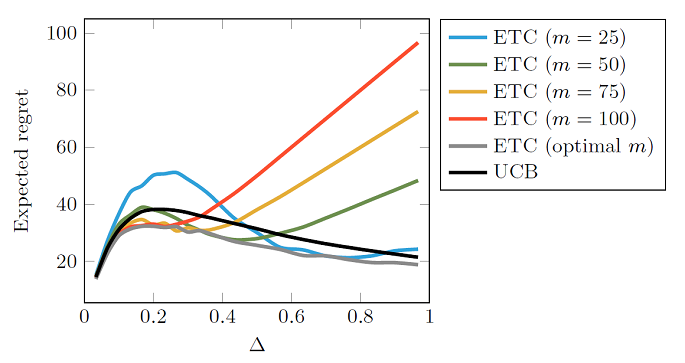


The figure was obtained in a Gaussian bandit scenario with arms $k=2$, variance $\sigma_1=\sigma_2=1$ and means $\mu_1=0$ and $\mu_2 =-\Delta$. The horizon is $n=1000$, and the suboptimality gap $\Delta$ is varied between 0 and 1. The expected regret of UCB is plotted against ETC for a variety of choices of commitment time $m$.


### Parameters

Below the declarations of all the parameters for the simulation, as well as the environments (one environment per each Δ we wish to evaluate) and the policies we want to simulate against these environments.

In [6]:
# simulation options
HORIZON      = int(1e3)                                                                             # duration of each environment
REPETITIONS  = int(2e3)                                                                             # repetition of each environment
N_JOBS       = -1                                                                                   # use all CPUs

# environments to be simulated
ARM_TYPE     = pb.Arms.UnboundedGaussian                                                            # type of arm to simulate
K            = 2                                                                                    # number of arms to simulate
MU           = 0.0                                                                                  # shared mean value
VAR          = 1.0                                                                                  # shared variance value
DELTA        = np.linspace(0, 1, 51)[1:]                                                            # possible values of delta (different from 0)
ENVIRONMENTS = [dict(arm_type=ARM_TYPE, params=[(MU, VAR), (MU - delta, VAR)]) for delta in DELTA]  # environment dictionaries    

# policies to be tested on simulated environments
POLICIES = [
    dict(archtype=ETC, params={'natural_m': 25}),
    dict(archtype=ETC, params={'natural_m': 50}),
    dict(archtype=ETC, params={'natural_m': 75}),
    dict(archtype=ETC, params={'natural_m': 100}),
    dict(archtype=ETC, params={'natural_m': None, 'optimal_m': True}), 
    dict(archtype=UCB, params={'delta': 1 / HORIZON**2})
]

### Simulation

All the environments simulations can be conveniently handled by the `Evaluator` object, which is then used to launch each environment in the loop. 

**❗ with the current settings, the simulation takes 2 hours to complete ❗**

In [7]:
with io.capture_output():
    evaluation = pb.Environment.Evaluator({
        'horizon':     HORIZON,          
        'repetitions': REPETITIONS,  
        'n_jobs':      N_JOBS,            
        'verbosity':   0,              
        'environment': ENVIRONMENTS,
        'policies':    POLICIES
    })

for envId, env in tqdm(enumerate(evaluation.envs), desc='Problems', total=len(evaluation.envs)):
    assert DELTA[envId] == env.arms[0].mu - env.arms[1].mu

    # set ETC natural number to optimal (has to be computed for each environment)
    m_opt = getOptimalNaturalNumber(evaluation.horizon, DELTA[envId])
    policies = evaluation.cfg['policies']
    for policyId, policy in enumerate(policies):
        if policy['archtype'] == ETC and policy['params'].get('optimal_m', False):
            policy['params']['natural_m'] = m_opt
        
    # run environment
    with io.capture_output():
        evaluation.startOneEnv(envId, env)

Problems:   0%|          | 0/50 [00:00<?, ?it/s]

### Visualization

Finally it is possible to plot the results from the previous simulations, that in theory should resemble Figure 7.1. For sake of time, we have run much fewer repetitions than the book's authors, so results might be less precise.

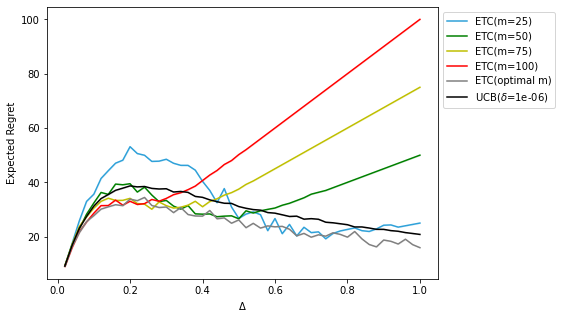

In [8]:
def do_plot(evaluation):
    fig, ax = mpl.pyplot.subplots(figsize=(7, 5))
    for policyId, color in zip(range(evaluation.nbPolicies), ['#2fa1d9', 'g', 'y', 'r', '#808080', 'k']):
        # get repetitions' final regrets for each environment
        regrets = [evaluation.getLastRegrets(policyId, envId) for envId in range(len(evaluation.envs))]

        # compute mean and std for the each environment's regret
        mean    = np.array([r.mean() for r in regrets]) 
        std     = np.array([r.std()  for r in regrets])

        # plot mean +/- std (std not really visible)
        ax.fill_between(DELTA, mean + std, mean - std, alpha=0.1, color=color)
        ax.plot(DELTA, mean, label=evaluation.policies[policyId], color=color)

    ax.set_xlabel(r'$\Delta$')
    ax.set_ylabel('Expected Regret')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    return fig

_ = do_plot(evaluation)

## (d) Design an on the effect of δ

To understand the effects of different choices of $\delta$ for the UCB algorithm, similarly to Figure 7.1, we can plot the simulated expected regret of UCB for dfferent values of $\delta$ listed below

1. $\delta=0.01$, a relatively large value
2. $\delta=10^{-6}$, the same value used in point (b) to reproduce Figure 7.1
3. $\delta=10^{-10}$, a relatively small value
4. $\delta=1 / t$, a time-dependent value that does not need knowledge on the horizon



### Parameters

In [11]:
REPETITIONS  = int(1e3)                                                                             

POLICIES = [
    dict(archtype=UCB, params={'delta': 1e4  / HORIZON**2}),
    dict(archtype=UCB, params={'delta': 1e0  / HORIZON**2}),
    dict(archtype=UCB, params={'delta': 1e-4 / HORIZON**2}),
    dict(archtype=pb.Policies.UCB, params={}) # delta is time-varying (= 1 / t)
]

### Simulation

**❗ with the current settings, the simulation takes 2 hours to complete ❗**

In [12]:
with io.capture_output():
    evaluation = pb.Environment.Evaluator({
        'horizon':     HORIZON,          
        'repetitions': REPETITIONS,  
        'n_jobs':      N_JOBS,            
        'verbosity':   0,              
        'environment': ENVIRONMENTS,
        'policies':    POLICIES
    })

for envId, env in tqdm(enumerate(evaluation.envs), desc='Problems', total=len(evaluation.envs)):
    assert DELTA[envId] == env.arms[0].mu - env.arms[1].mu
    with io.capture_output():
        evaluation.startOneEnv(envId, env)

Problems:   0%|          | 0/50 [00:00<?, ?it/s]

### Visualization

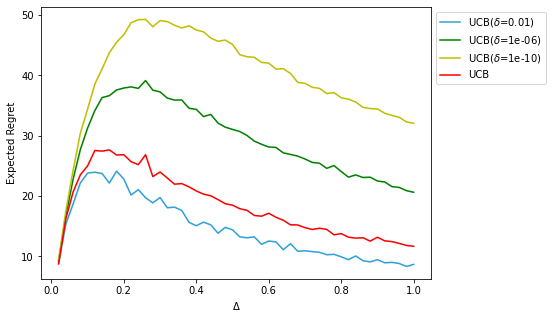

In [13]:
_ = do_plot(evaluation)